In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image

from utils_new import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

In [2]:
def to_onehot(x, n, device=None):
    if isinstance(x, np.ndarray):
        x = torch.Tensor(x).to(torch.long)
    one_hot = torch.zeros((x.shape[0], n))
    one_hot.scatter_(1, x[:, None], 1.)
    if device is not None:
        one_hot = one_hot.to(device)
    return one_hot

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [4]:
import sys

In [5]:
root_folder = 'FC_GAE_results'
fixed_folder = root_folder + '/Fixed_results/'
recon_folder = root_folder + '/Recon_results/'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(recon_folder)

In [6]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
                lambda x: x.to(device)
           ])

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

lr = 0.0001
prior_size = 10
train_epoch = 1000
batch_size = 250
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((10, prior_size)).repeat((1,10)).view(-1, prior_size).to(device)
fixed_z_label = to_onehot(torch.tensor(list(range(10))).repeat((10)), 10).to(device)
fixed_data, fixed_label = next(iter(test_loader))
fixed_data = fixed_data[:100].to(device)
fixed_label = to_onehot(fixed_label[:100], 10).to(device)

cpu


In [8]:
data, label = next(iter(train_loader))

In [9]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, 
                 last_fn=None, first_fn=None, device='cpu'):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        if first_fn is not None:
            layers.append(first_fn)
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        self.to(device)
        
    def forward(self, x, y=None):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        if y is not None:
            x = torch.cat([x, y], dim=1)
        return self.model(x)

In [10]:
Enc = FullyConnected([28*28, 1024, 1024, prior_size], activation_fn=nn.LeakyReLU(0.2), flatten=True, device=device)

Dec = FullyConnected([prior_size, 1024, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh(), device=device)
Disc = FullyConnected([prior_size, 1024, 1024, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), device=device)

Enc_optimizer = optim.Adam(Enc.parameters(), lr=lr)
Dec_optimizer = optim.Adam(Dec.parameters(), lr=lr)
Disc_optimizer = optim.Adam(Disc.parameters(), lr=lr)

In [11]:
train_log = {'E': [],'AE': [], 'D': []}
test_log = {'E': [],'AE': [], 'D': []}

In [12]:
batch_zeros = torch.zeros((batch_size, 1)).to(device)
batch_ones = torch.ones((batch_size, 1)).to(device)

In [13]:
def train(epoch, Enc, Dec, Disc, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, label) in enumerate(train_loader):
        label = to_onehot(label, 10, device)
        # train D
        Enc.zero_grad()
        Disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size)).to(device)

        fake_pred = Disc(Enc(data))
        true_pred = Disc(z)

        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        Disc_loss = 0.5*(fake_loss + true_loss)
        
        Disc_loss.backward()
        Disc_optimizer.step()
        # train AE
        Enc.zero_grad()
        Dec.zero_grad()
        Disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size))
        
        latent = Enc(data)
        
        reconstructed = Dec(latent).view(-1, 1, 28, 28)
        fake_pred = Disc(latent)
        
        Enc_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        AE_loss = F.mse_loss(reconstructed, data)
        G_loss = AE_loss + Enc_loss
        
        G_loss.backward()
        Dec_optimizer.step()
        Enc_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_loss.item(), AE_loss.item(), Disc_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_loss.item(), AE_loss.item(), Disc_loss.item())
        print(line + losses)
        log['E'].append(Enc_loss.item())
        log['AE'].append(AE_loss.item())
        log['D'].append(Disc_loss.item())

In [18]:
def test(Enc, Dec, Disc, loader, epoch, log=None):
    test_size = len(loader)
    E_loss = 0.
    AE_loss = 0.
    D_loss = 0.
    test_loss = {'E': 0., 'AE': 0., 'D': 0.}
    with torch.no_grad():
        for data, label in loader:
            label = to_onehot(label, 10, device)
            z = torch.randn((batch_size, prior_size)).to(device)
            latent = Enc(data)
            reconstructed = Dec(latent).view(-1, 1, 28, 28)
            fake_pred = Disc(latent)
            true_pred = Disc(z)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            E_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
            AE_loss += F.mse_loss(reconstructed, data).item()
            #sys.getsizeof(AE_loss)
            
        E_loss /= test_size
        D_loss /= test_size
        AE_loss /= test_size
        #AE_loss = D_loss

        fixed_gen = Dec(fixed_z).cpu().data.numpy().reshape(100, 1, 28, 28)
        #plot_mnist(fixed_gen, (10, 10), False, fixed_folder + '%03d.png' % epoch)
        fixed_reconstruction = Dec(Enc(fixed_data)).cpu().data.numpy().reshape(100, 1, 28, 28)
        #plot_mnist(fixed_reconstruction, (10, 10), False, recon_folder + '%03d.png' % epoch)
        
    report = 'Test losses. E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(E_loss, AE_loss, D_loss)
    print(report)
    print(sys.getsizeof(AE_loss))

In [19]:
for epoch in range(1, 1001):
    Enc.train()
    Dec.train()
    Disc.train()
    train(epoch, Enc, Dec, Disc, train_log)
    Enc.eval()
    Dec.eval()
    Disc.eval()
    test(Enc, Dec, Disc, valid_loader, epoch, test_log)
    

Train Epoch: 1 [0/50000 (0%)]	Losses E: 0.5648, AE: 0.1945, D: 0.7139
Train Epoch: 1 [25000/50000 (50%)]	Losses E: 1.1534, AE: 0.1952, D: 0.6171
Train Epoch: 1 [50000/50000 (100%)]	Losses E: 0.6724, AE: 0.1910, D: 0.7101
Test losses. E: 0.6692, AE: 0.1892, D: 0.7095
24
Train Epoch: 2 [0/50000 (0%)]	Losses E: 0.6696, AE: 0.1908, D: 0.7103
Train Epoch: 2 [25000/50000 (50%)]	Losses E: 0.5864, AE: 0.1918, D: 0.6914
Train Epoch: 2 [50000/50000 (100%)]	Losses E: 0.8582, AE: 0.1909, D: 0.7764
Test losses. E: 0.8344, AE: 0.1958, D: 0.7781
24
Train Epoch: 3 [0/50000 (0%)]	Losses E: 0.8422, AE: 0.1919, D: 0.7806
Train Epoch: 3 [25000/50000 (50%)]	Losses E: 0.6383, AE: 0.1650, D: 0.7012
Train Epoch: 3 [50000/50000 (100%)]	Losses E: 0.5389, AE: 0.1649, D: 0.7782
Test losses. E: 0.5328, AE: 0.1635, D: 0.7706
24
Train Epoch: 4 [0/50000 (0%)]	Losses E: 0.5369, AE: 0.1696, D: 0.7726
Train Epoch: 4 [25000/50000 (50%)]	Losses E: 0.6070, AE: 0.1589, D: 0.7674
Train Epoch: 4 [50000/50000 (100%)]	Losses E:

Train Epoch: 31 [25000/50000 (50%)]	Losses E: 0.7702, AE: 0.1250, D: 0.7151
Train Epoch: 31 [50000/50000 (100%)]	Losses E: 0.6222, AE: 0.1222, D: 0.7248
Test losses. E: 0.6110, AE: 0.1166, D: 0.7287
24
Train Epoch: 32 [0/50000 (0%)]	Losses E: 0.6156, AE: 0.1229, D: 0.7324
Train Epoch: 32 [25000/50000 (50%)]	Losses E: 0.7390, AE: 0.1816, D: 0.7314
Train Epoch: 32 [50000/50000 (100%)]	Losses E: 0.6740, AE: 0.1329, D: 0.7057
Test losses. E: 0.6687, AE: 0.1270, D: 0.7059
24
Train Epoch: 33 [0/50000 (0%)]	Losses E: 0.6794, AE: 0.1239, D: 0.7051
Train Epoch: 33 [25000/50000 (50%)]	Losses E: 0.6733, AE: 0.1054, D: 0.7055
Train Epoch: 33 [50000/50000 (100%)]	Losses E: 0.6878, AE: 0.1030, D: 0.6980
Test losses. E: 0.6851, AE: 0.0989, D: 0.6990
24
Train Epoch: 34 [0/50000 (0%)]	Losses E: 0.6857, AE: 0.0984, D: 0.7004
Train Epoch: 34 [25000/50000 (50%)]	Losses E: 0.7091, AE: 0.0950, D: 0.6952
Train Epoch: 34 [50000/50000 (100%)]	Losses E: 0.6813, AE: 0.0868, D: 0.6948
Test losses. E: 0.6777, AE: 

Train Epoch: 61 [50000/50000 (100%)]	Losses E: 0.7025, AE: 0.0882, D: 0.6969
Test losses. E: 0.6991, AE: 0.0908, D: 0.6948
24
Train Epoch: 62 [0/50000 (0%)]	Losses E: 0.7036, AE: 0.0892, D: 0.6949
Train Epoch: 62 [25000/50000 (50%)]	Losses E: 0.6593, AE: 0.0910, D: 0.7081
Train Epoch: 62 [50000/50000 (100%)]	Losses E: 0.6530, AE: 0.1149, D: 0.7028
Test losses. E: 0.6505, AE: 0.1170, D: 0.6986
24
Train Epoch: 63 [0/50000 (0%)]	Losses E: 0.6594, AE: 0.1215, D: 0.6975
Train Epoch: 63 [25000/50000 (50%)]	Losses E: 0.6438, AE: 0.1099, D: 0.7139
Train Epoch: 63 [50000/50000 (100%)]	Losses E: 0.6240, AE: 0.1125, D: 0.7259
Test losses. E: 0.6180, AE: 0.1105, D: 0.7245
24
Train Epoch: 64 [0/50000 (0%)]	Losses E: 0.6246, AE: 0.1172, D: 0.7246
Train Epoch: 64 [25000/50000 (50%)]	Losses E: 0.6847, AE: 0.0972, D: 0.7021
Train Epoch: 64 [50000/50000 (100%)]	Losses E: 0.7129, AE: 0.0865, D: 0.7028
Test losses. E: 0.7126, AE: 0.0888, D: 0.7010
24
Train Epoch: 65 [0/50000 (0%)]	Losses E: 0.7153, AE: 0.

Test losses. E: 0.7121, AE: 0.0653, D: 0.6918
24
Train Epoch: 92 [0/50000 (0%)]	Losses E: 0.7164, AE: 0.0674, D: 0.6921
Train Epoch: 92 [25000/50000 (50%)]	Losses E: 0.6896, AE: 0.0609, D: 0.6924
Train Epoch: 92 [50000/50000 (100%)]	Losses E: 0.6915, AE: 0.0634, D: 0.6958
Test losses. E: 0.6907, AE: 0.0661, D: 0.6953
24
Train Epoch: 93 [0/50000 (0%)]	Losses E: 0.6964, AE: 0.0659, D: 0.6963
Train Epoch: 93 [25000/50000 (50%)]	Losses E: 0.7128, AE: 0.0645, D: 0.6955
Train Epoch: 93 [50000/50000 (100%)]	Losses E: 0.6809, AE: 0.0579, D: 0.6916
Test losses. E: 0.6804, AE: 0.0641, D: 0.6923
24
Train Epoch: 94 [0/50000 (0%)]	Losses E: 0.6811, AE: 0.0630, D: 0.6925
Train Epoch: 94 [25000/50000 (50%)]	Losses E: 0.6979, AE: 0.0669, D: 0.6932
Train Epoch: 94 [50000/50000 (100%)]	Losses E: 0.7174, AE: 0.0631, D: 0.6931
Test losses. E: 0.7166, AE: 0.0641, D: 0.6934
24
Train Epoch: 95 [0/50000 (0%)]	Losses E: 0.7198, AE: 0.0668, D: 0.6920
Train Epoch: 95 [25000/50000 (50%)]	Losses E: 0.7153, AE: 0.0

Test losses. E: 0.6666, AE: 0.0571, D: 0.6920
24
Train Epoch: 122 [0/50000 (0%)]	Losses E: 0.6665, AE: 0.0549, D: 0.6934
Train Epoch: 122 [25000/50000 (50%)]	Losses E: 0.6885, AE: 0.0546, D: 0.6929
Train Epoch: 122 [50000/50000 (100%)]	Losses E: 0.7100, AE: 0.0549, D: 0.6940
Test losses. E: 0.7107, AE: 0.0562, D: 0.6930
24
Train Epoch: 123 [0/50000 (0%)]	Losses E: 0.7108, AE: 0.0535, D: 0.6940
Train Epoch: 123 [25000/50000 (50%)]	Losses E: 0.7181, AE: 0.0573, D: 0.6923
Train Epoch: 123 [50000/50000 (100%)]	Losses E: 0.7103, AE: 0.0533, D: 0.6915
Test losses. E: 0.7108, AE: 0.0579, D: 0.6917
24
Train Epoch: 124 [0/50000 (0%)]	Losses E: 0.7139, AE: 0.0546, D: 0.6918
Train Epoch: 124 [25000/50000 (50%)]	Losses E: 0.6853, AE: 0.0584, D: 0.6981
Train Epoch: 124 [50000/50000 (100%)]	Losses E: 0.6566, AE: 0.0560, D: 0.6946
Test losses. E: 0.6536, AE: 0.0611, D: 0.6952
24
Train Epoch: 125 [0/50000 (0%)]	Losses E: 0.6563, AE: 0.0581, D: 0.6953
Train Epoch: 125 [25000/50000 (50%)]	Losses E: 0.66

Train Epoch: 151 [50000/50000 (100%)]	Losses E: 0.6460, AE: 0.0544, D: 0.6902
Test losses. E: 0.6459, AE: 0.0550, D: 0.6918
24
Train Epoch: 152 [0/50000 (0%)]	Losses E: 0.6453, AE: 0.0515, D: 0.6930
Train Epoch: 152 [25000/50000 (50%)]	Losses E: 0.7348, AE: 0.0709, D: 0.6931
Train Epoch: 152 [50000/50000 (100%)]	Losses E: 0.6658, AE: 0.0756, D: 0.7048
Test losses. E: 0.6623, AE: 0.0756, D: 0.7060
24
Train Epoch: 153 [0/50000 (0%)]	Losses E: 0.6597, AE: 0.0754, D: 0.7066
Train Epoch: 153 [25000/50000 (50%)]	Losses E: 0.6369, AE: 0.0619, D: 0.7004
Train Epoch: 153 [50000/50000 (100%)]	Losses E: 0.6687, AE: 0.0527, D: 0.6935
Test losses. E: 0.6673, AE: 0.0553, D: 0.6943
24
Train Epoch: 154 [0/50000 (0%)]	Losses E: 0.6670, AE: 0.0523, D: 0.6953
Train Epoch: 154 [25000/50000 (50%)]	Losses E: 0.7098, AE: 0.0487, D: 0.6936
Train Epoch: 154 [50000/50000 (100%)]	Losses E: 0.7157, AE: 0.0527, D: 0.6923
Test losses. E: 0.7152, AE: 0.0541, D: 0.6919
24
Train Epoch: 155 [0/50000 (0%)]	Losses E: 0.7

Train Epoch: 181 [25000/50000 (50%)]	Losses E: 0.7163, AE: 0.0528, D: 0.6935
Train Epoch: 181 [50000/50000 (100%)]	Losses E: 0.7190, AE: 0.0518, D: 0.6921
Test losses. E: 0.7167, AE: 0.0535, D: 0.6926
24
Train Epoch: 182 [0/50000 (0%)]	Losses E: 0.7165, AE: 0.0467, D: 0.6936
Train Epoch: 182 [25000/50000 (50%)]	Losses E: 0.7222, AE: 0.0517, D: 0.6937
Train Epoch: 182 [50000/50000 (100%)]	Losses E: 0.7136, AE: 0.0535, D: 0.6964
Test losses. E: 0.7122, AE: 0.0560, D: 0.6945
24
Train Epoch: 183 [0/50000 (0%)]	Losses E: 0.7166, AE: 0.0541, D: 0.6932
Train Epoch: 183 [25000/50000 (50%)]	Losses E: 0.7065, AE: 0.0458, D: 0.6966
Train Epoch: 183 [50000/50000 (100%)]	Losses E: 0.7030, AE: 0.0456, D: 0.6919
Test losses. E: 0.7015, AE: 0.0518, D: 0.6941
24
Train Epoch: 184 [0/50000 (0%)]	Losses E: 0.6978, AE: 0.0448, D: 0.6980
Train Epoch: 184 [25000/50000 (50%)]	Losses E: 0.7237, AE: 0.0469, D: 0.6942
Train Epoch: 184 [50000/50000 (100%)]	Losses E: 0.7320, AE: 0.0502, D: 0.6896
Test losses. E: 0

Train Epoch: 211 [0/50000 (0%)]	Losses E: 0.6659, AE: 0.0427, D: 0.6936
Train Epoch: 211 [25000/50000 (50%)]	Losses E: 0.6975, AE: 0.0455, D: 0.6922
Train Epoch: 211 [50000/50000 (100%)]	Losses E: 0.6928, AE: 0.0480, D: 0.6912
Test losses. E: 0.6898, AE: 0.0493, D: 0.6928
24
Train Epoch: 212 [0/50000 (0%)]	Losses E: 0.6902, AE: 0.0435, D: 0.6931
Train Epoch: 212 [25000/50000 (50%)]	Losses E: 0.6833, AE: 0.0459, D: 0.6970
Train Epoch: 212 [50000/50000 (100%)]	Losses E: 0.7059, AE: 0.0448, D: 0.6946
Test losses. E: 0.7026, AE: 0.0512, D: 0.6948
24
Train Epoch: 213 [0/50000 (0%)]	Losses E: 0.6998, AE: 0.0476, D: 0.6952
Train Epoch: 213 [25000/50000 (50%)]	Losses E: 0.6945, AE: 0.0467, D: 0.6952
Train Epoch: 213 [50000/50000 (100%)]	Losses E: 0.7151, AE: 0.0460, D: 0.6922
Test losses. E: 0.7135, AE: 0.0493, D: 0.6922
24
Train Epoch: 214 [0/50000 (0%)]	Losses E: 0.7130, AE: 0.0421, D: 0.6938
Train Epoch: 214 [25000/50000 (50%)]	Losses E: 0.7162, AE: 0.0442, D: 0.6922
Train Epoch: 214 [50000

Test losses. E: 0.6999, AE: 0.0491, D: 0.6924
24
Train Epoch: 241 [0/50000 (0%)]	Losses E: 0.6984, AE: 0.0418, D: 0.6933
Train Epoch: 241 [25000/50000 (50%)]	Losses E: 0.6931, AE: 0.0400, D: 0.6936
Train Epoch: 241 [50000/50000 (100%)]	Losses E: 0.6955, AE: 0.0407, D: 0.6933
Test losses. E: 0.6949, AE: 0.0496, D: 0.6929
24
Train Epoch: 242 [0/50000 (0%)]	Losses E: 0.6956, AE: 0.0409, D: 0.6926
Train Epoch: 242 [25000/50000 (50%)]	Losses E: 0.7057, AE: 0.0441, D: 0.6911
Train Epoch: 242 [50000/50000 (100%)]	Losses E: 0.6905, AE: 0.0430, D: 0.6948
Test losses. E: 0.6883, AE: 0.0510, D: 0.6941
24
Train Epoch: 243 [0/50000 (0%)]	Losses E: 0.6948, AE: 0.0451, D: 0.6941
Train Epoch: 243 [25000/50000 (50%)]	Losses E: 0.6898, AE: 0.0413, D: 0.6928
Train Epoch: 243 [50000/50000 (100%)]	Losses E: 0.6974, AE: 0.0464, D: 0.6971
Test losses. E: 0.6947, AE: 0.0529, D: 0.6956
24
Train Epoch: 244 [0/50000 (0%)]	Losses E: 0.6979, AE: 0.0497, D: 0.6966
Train Epoch: 244 [25000/50000 (50%)]	Losses E: 0.69

Train Epoch: 270 [50000/50000 (100%)]	Losses E: 0.6881, AE: 0.0403, D: 0.6948
Test losses. E: 0.6884, AE: 0.0470, D: 0.6922
24
Train Epoch: 271 [0/50000 (0%)]	Losses E: 0.6883, AE: 0.0419, D: 0.6918
Train Epoch: 271 [25000/50000 (50%)]	Losses E: 0.6942, AE: 0.0412, D: 0.6930
Train Epoch: 271 [50000/50000 (100%)]	Losses E: 0.7005, AE: 0.0400, D: 0.6945
Test losses. E: 0.7022, AE: 0.0473, D: 0.6924
24
Train Epoch: 272 [0/50000 (0%)]	Losses E: 0.7041, AE: 0.0394, D: 0.6921
Train Epoch: 272 [25000/50000 (50%)]	Losses E: 0.6999, AE: 0.0415, D: 0.6928
Train Epoch: 272 [50000/50000 (100%)]	Losses E: 0.7020, AE: 0.0390, D: 0.6923
Test losses. E: 0.6986, AE: 0.0477, D: 0.6923
24
Train Epoch: 273 [0/50000 (0%)]	Losses E: 0.7020, AE: 0.0383, D: 0.6930
Train Epoch: 273 [25000/50000 (50%)]	Losses E: 0.6985, AE: 0.0408, D: 0.6918
Train Epoch: 273 [50000/50000 (100%)]	Losses E: 0.7085, AE: 0.0388, D: 0.6922
Test losses. E: 0.7079, AE: 0.0473, D: 0.6921
24
Train Epoch: 274 [0/50000 (0%)]	Losses E: 0.7

Train Epoch: 300 [25000/50000 (50%)]	Losses E: 0.7037, AE: 0.0394, D: 0.6931
Train Epoch: 300 [50000/50000 (100%)]	Losses E: 0.7127, AE: 0.0417, D: 0.6927
Test losses. E: 0.7105, AE: 0.0471, D: 0.6920
24
Train Epoch: 301 [0/50000 (0%)]	Losses E: 0.7099, AE: 0.0386, D: 0.6937
Train Epoch: 301 [25000/50000 (50%)]	Losses E: 0.6961, AE: 0.0377, D: 0.6918
Train Epoch: 301 [50000/50000 (100%)]	Losses E: 0.6947, AE: 0.0410, D: 0.6919
Test losses. E: 0.6945, AE: 0.0474, D: 0.6924
24
Train Epoch: 302 [0/50000 (0%)]	Losses E: 0.6956, AE: 0.0376, D: 0.6919
Train Epoch: 302 [25000/50000 (50%)]	Losses E: 0.6774, AE: 0.0393, D: 0.6946
Train Epoch: 302 [50000/50000 (100%)]	Losses E: 0.6679, AE: 0.0447, D: 0.6958
Test losses. E: 0.6625, AE: 0.0513, D: 0.6956
24
Train Epoch: 303 [0/50000 (0%)]	Losses E: 0.6641, AE: 0.0419, D: 0.6971
Train Epoch: 303 [25000/50000 (50%)]	Losses E: 0.6969, AE: 0.0397, D: 0.6938
Train Epoch: 303 [50000/50000 (100%)]	Losses E: 0.6927, AE: 0.0386, D: 0.6940
Test losses. E: 0

Train Epoch: 330 [0/50000 (0%)]	Losses E: 0.6939, AE: 0.0355, D: 0.6939
Train Epoch: 330 [25000/50000 (50%)]	Losses E: 0.7001, AE: 0.0361, D: 0.6936
Train Epoch: 330 [50000/50000 (100%)]	Losses E: 0.7017, AE: 0.0369, D: 0.6931
Test losses. E: 0.7023, AE: 0.0475, D: 0.6924
24
Train Epoch: 331 [0/50000 (0%)]	Losses E: 0.7073, AE: 0.0347, D: 0.6910
Train Epoch: 331 [25000/50000 (50%)]	Losses E: 0.6959, AE: 0.0391, D: 0.6926
Train Epoch: 331 [50000/50000 (100%)]	Losses E: 0.7024, AE: 0.0379, D: 0.6928
Test losses. E: 0.6989, AE: 0.0473, D: 0.6927
24
Train Epoch: 332 [0/50000 (0%)]	Losses E: 0.6996, AE: 0.0372, D: 0.6929
Train Epoch: 332 [25000/50000 (50%)]	Losses E: 0.6843, AE: 0.0382, D: 0.6956
Train Epoch: 332 [50000/50000 (100%)]	Losses E: 0.6830, AE: 0.0383, D: 0.6914
Test losses. E: 0.6795, AE: 0.0474, D: 0.6926
24
Train Epoch: 333 [0/50000 (0%)]	Losses E: 0.6828, AE: 0.0345, D: 0.6923
Train Epoch: 333 [25000/50000 (50%)]	Losses E: 0.6854, AE: 0.0379, D: 0.6953
Train Epoch: 333 [50000

Test losses. E: 0.6968, AE: 0.0470, D: 0.6923
24
Train Epoch: 360 [0/50000 (0%)]	Losses E: 0.6981, AE: 0.0369, D: 0.6929
Train Epoch: 360 [25000/50000 (50%)]	Losses E: 0.6955, AE: 0.0360, D: 0.6921
Train Epoch: 360 [50000/50000 (100%)]	Losses E: 0.7027, AE: 0.0332, D: 0.6918
Test losses. E: 0.7014, AE: 0.0467, D: 0.6918
24
Train Epoch: 361 [0/50000 (0%)]	Losses E: 0.7048, AE: 0.0348, D: 0.6938
Train Epoch: 361 [25000/50000 (50%)]	Losses E: 0.7012, AE: 0.0383, D: 0.6930
Train Epoch: 361 [50000/50000 (100%)]	Losses E: 0.6927, AE: 0.0341, D: 0.6938
Test losses. E: 0.6910, AE: 0.0465, D: 0.6916
24
Train Epoch: 362 [0/50000 (0%)]	Losses E: 0.6913, AE: 0.0354, D: 0.6922
Train Epoch: 362 [25000/50000 (50%)]	Losses E: 0.6974, AE: 0.0379, D: 0.6921
Train Epoch: 362 [50000/50000 (100%)]	Losses E: 0.6924, AE: 0.0353, D: 0.6921
Test losses. E: 0.6894, AE: 0.0473, D: 0.6923
24
Train Epoch: 363 [0/50000 (0%)]	Losses E: 0.6889, AE: 0.0386, D: 0.6920
Train Epoch: 363 [25000/50000 (50%)]	Losses E: 0.70

Train Epoch: 389 [50000/50000 (100%)]	Losses E: 0.7070, AE: 0.0355, D: 0.6925
Test losses. E: 0.7057, AE: 0.0472, D: 0.6920
24
Train Epoch: 390 [0/50000 (0%)]	Losses E: 0.7044, AE: 0.0353, D: 0.6940
Train Epoch: 390 [25000/50000 (50%)]	Losses E: 0.7141, AE: 0.0368, D: 0.6944
Train Epoch: 390 [50000/50000 (100%)]	Losses E: 0.6935, AE: 0.0380, D: 0.6944
Test losses. E: 0.6895, AE: 0.0478, D: 0.6929
24
Train Epoch: 391 [0/50000 (0%)]	Losses E: 0.6926, AE: 0.0365, D: 0.6944
Train Epoch: 391 [25000/50000 (50%)]	Losses E: 0.6898, AE: 0.0353, D: 0.6940
Train Epoch: 391 [50000/50000 (100%)]	Losses E: 0.6910, AE: 0.0365, D: 0.6935
Test losses. E: 0.6921, AE: 0.0476, D: 0.6929
24
Train Epoch: 392 [0/50000 (0%)]	Losses E: 0.6917, AE: 0.0370, D: 0.6945
Train Epoch: 392 [25000/50000 (50%)]	Losses E: 0.6825, AE: 0.0338, D: 0.6918
Train Epoch: 392 [50000/50000 (100%)]	Losses E: 0.6813, AE: 0.0343, D: 0.6951
Test losses. E: 0.6802, AE: 0.0475, D: 0.6928
24
Train Epoch: 393 [0/50000 (0%)]	Losses E: 0.6

Train Epoch: 419 [25000/50000 (50%)]	Losses E: 0.7036, AE: 0.0316, D: 0.6915
Train Epoch: 419 [50000/50000 (100%)]	Losses E: 0.6919, AE: 0.0350, D: 0.6903
Test losses. E: 0.6887, AE: 0.0469, D: 0.6919
24
Train Epoch: 420 [0/50000 (0%)]	Losses E: 0.6916, AE: 0.0332, D: 0.6927
Train Epoch: 420 [25000/50000 (50%)]	Losses E: 0.6882, AE: 0.0331, D: 0.6921
Train Epoch: 420 [50000/50000 (100%)]	Losses E: 0.6974, AE: 0.0351, D: 0.6921
Test losses. E: 0.6946, AE: 0.0473, D: 0.6923
24
Train Epoch: 421 [0/50000 (0%)]	Losses E: 0.6972, AE: 0.0337, D: 0.6909
Train Epoch: 421 [25000/50000 (50%)]	Losses E: 0.6877, AE: 0.0355, D: 0.6929
Train Epoch: 421 [50000/50000 (100%)]	Losses E: 0.6977, AE: 0.0342, D: 0.6922
Test losses. E: 0.6952, AE: 0.0473, D: 0.6919
24
Train Epoch: 422 [0/50000 (0%)]	Losses E: 0.6953, AE: 0.0341, D: 0.6943
Train Epoch: 422 [25000/50000 (50%)]	Losses E: 0.6985, AE: 0.0361, D: 0.6920
Train Epoch: 422 [50000/50000 (100%)]	Losses E: 0.7027, AE: 0.0353, D: 0.6934
Test losses. E: 0

Train Epoch: 449 [0/50000 (0%)]	Losses E: 0.6989, AE: 0.0331, D: 0.6933
Train Epoch: 449 [25000/50000 (50%)]	Losses E: 0.6992, AE: 0.0334, D: 0.6922
Train Epoch: 449 [50000/50000 (100%)]	Losses E: 0.7103, AE: 0.0367, D: 0.6918
Test losses. E: 0.7046, AE: 0.0477, D: 0.6922
24
Train Epoch: 450 [0/50000 (0%)]	Losses E: 0.7069, AE: 0.0345, D: 0.6928
Train Epoch: 450 [25000/50000 (50%)]	Losses E: 0.7064, AE: 0.0350, D: 0.6939
Train Epoch: 450 [50000/50000 (100%)]	Losses E: 0.7038, AE: 0.0347, D: 0.6923
Test losses. E: 0.7031, AE: 0.0473, D: 0.6921
24
Train Epoch: 451 [0/50000 (0%)]	Losses E: 0.7012, AE: 0.0345, D: 0.6906
Train Epoch: 451 [25000/50000 (50%)]	Losses E: 0.6975, AE: 0.0320, D: 0.6934
Train Epoch: 451 [50000/50000 (100%)]	Losses E: 0.7050, AE: 0.0361, D: 0.6937
Test losses. E: 0.7018, AE: 0.0474, D: 0.6923
24
Train Epoch: 452 [0/50000 (0%)]	Losses E: 0.7013, AE: 0.0332, D: 0.6931
Train Epoch: 452 [25000/50000 (50%)]	Losses E: 0.6981, AE: 0.0347, D: 0.6923
Train Epoch: 452 [50000

Test losses. E: 0.6958, AE: 0.0475, D: 0.6924
24
Train Epoch: 479 [0/50000 (0%)]	Losses E: 0.6970, AE: 0.0320, D: 0.6919
Train Epoch: 479 [25000/50000 (50%)]	Losses E: 0.6891, AE: 0.0351, D: 0.6939
Train Epoch: 479 [50000/50000 (100%)]	Losses E: 0.6888, AE: 0.0330, D: 0.6913
Test losses. E: 0.6855, AE: 0.0475, D: 0.6920
24
Train Epoch: 480 [0/50000 (0%)]	Losses E: 0.6906, AE: 0.0306, D: 0.6939
Train Epoch: 480 [25000/50000 (50%)]	Losses E: 0.6916, AE: 0.0351, D: 0.6930
Train Epoch: 480 [50000/50000 (100%)]	Losses E: 0.6999, AE: 0.0319, D: 0.6951
Test losses. E: 0.6985, AE: 0.0479, D: 0.6921
24
Train Epoch: 481 [0/50000 (0%)]	Losses E: 0.7025, AE: 0.0337, D: 0.6924
Train Epoch: 481 [25000/50000 (50%)]	Losses E: 0.6976, AE: 0.0334, D: 0.6937
Train Epoch: 481 [50000/50000 (100%)]	Losses E: 0.6959, AE: 0.0362, D: 0.6942
Test losses. E: 0.6934, AE: 0.0470, D: 0.6919
24
Train Epoch: 482 [0/50000 (0%)]	Losses E: 0.6958, AE: 0.0303, D: 0.6928
Train Epoch: 482 [25000/50000 (50%)]	Losses E: 0.69

Train Epoch: 508 [50000/50000 (100%)]	Losses E: 0.6892, AE: 0.0317, D: 0.6939
Test losses. E: 0.6908, AE: 0.0471, D: 0.6921
24
Train Epoch: 509 [0/50000 (0%)]	Losses E: 0.6904, AE: 0.0305, D: 0.6934
Train Epoch: 509 [25000/50000 (50%)]	Losses E: 0.6901, AE: 0.0309, D: 0.6918
Train Epoch: 509 [50000/50000 (100%)]	Losses E: 0.6965, AE: 0.0316, D: 0.6927
Test losses. E: 0.6937, AE: 0.0482, D: 0.6920
24
Train Epoch: 510 [0/50000 (0%)]	Losses E: 0.6953, AE: 0.0333, D: 0.6914
Train Epoch: 510 [25000/50000 (50%)]	Losses E: 0.6955, AE: 0.0318, D: 0.6916
Train Epoch: 510 [50000/50000 (100%)]	Losses E: 0.6952, AE: 0.0329, D: 0.6943
Test losses. E: 0.6945, AE: 0.0480, D: 0.6925
24
Train Epoch: 511 [0/50000 (0%)]	Losses E: 0.6989, AE: 0.0319, D: 0.6928
Train Epoch: 511 [25000/50000 (50%)]	Losses E: 0.6911, AE: 0.0340, D: 0.6927
Train Epoch: 511 [50000/50000 (100%)]	Losses E: 0.6931, AE: 0.0328, D: 0.6935
Test losses. E: 0.6921, AE: 0.0477, D: 0.6925
24
Train Epoch: 512 [0/50000 (0%)]	Losses E: 0.6

Train Epoch: 538 [25000/50000 (50%)]	Losses E: 0.7000, AE: 0.0318, D: 0.6917
Train Epoch: 538 [50000/50000 (100%)]	Losses E: 0.6974, AE: 0.0317, D: 0.6916
Test losses. E: 0.6973, AE: 0.0476, D: 0.6923
24
Train Epoch: 539 [0/50000 (0%)]	Losses E: 0.7011, AE: 0.0324, D: 0.6920
Train Epoch: 539 [25000/50000 (50%)]	Losses E: 0.6969, AE: 0.0334, D: 0.6950
Train Epoch: 539 [50000/50000 (100%)]	Losses E: 0.6907, AE: 0.0330, D: 0.6913
Test losses. E: 0.6857, AE: 0.0479, D: 0.6922
24
Train Epoch: 540 [0/50000 (0%)]	Losses E: 0.6880, AE: 0.0328, D: 0.6949
Train Epoch: 540 [25000/50000 (50%)]	Losses E: 0.6930, AE: 0.0312, D: 0.6932
Train Epoch: 540 [50000/50000 (100%)]	Losses E: 0.6912, AE: 0.0292, D: 0.6923
Test losses. E: 0.6900, AE: 0.0473, D: 0.6920
24
Train Epoch: 541 [0/50000 (0%)]	Losses E: 0.6922, AE: 0.0316, D: 0.6914
Train Epoch: 541 [25000/50000 (50%)]	Losses E: 0.6953, AE: 0.0319, D: 0.6944
Train Epoch: 541 [50000/50000 (100%)]	Losses E: 0.6945, AE: 0.0305, D: 0.6931
Test losses. E: 0

Train Epoch: 568 [0/50000 (0%)]	Losses E: 0.6943, AE: 0.0316, D: 0.6944
Train Epoch: 568 [25000/50000 (50%)]	Losses E: 0.6972, AE: 0.0317, D: 0.6934
Train Epoch: 568 [50000/50000 (100%)]	Losses E: 0.6943, AE: 0.0316, D: 0.6921
Test losses. E: 0.6918, AE: 0.0478, D: 0.6921
24
Train Epoch: 569 [0/50000 (0%)]	Losses E: 0.6910, AE: 0.0322, D: 0.6952
Train Epoch: 569 [25000/50000 (50%)]	Losses E: 0.6952, AE: 0.0308, D: 0.6937
Train Epoch: 569 [50000/50000 (100%)]	Losses E: 0.6945, AE: 0.0308, D: 0.6919
Test losses. E: 0.6921, AE: 0.0479, D: 0.6921
24
Train Epoch: 570 [0/50000 (0%)]	Losses E: 0.6938, AE: 0.0313, D: 0.6918
Train Epoch: 570 [25000/50000 (50%)]	Losses E: 0.6922, AE: 0.0297, D: 0.6930
Train Epoch: 570 [50000/50000 (100%)]	Losses E: 0.6937, AE: 0.0321, D: 0.6924
Test losses. E: 0.6925, AE: 0.0485, D: 0.6925
24
Train Epoch: 571 [0/50000 (0%)]	Losses E: 0.6975, AE: 0.0312, D: 0.6928
Train Epoch: 571 [25000/50000 (50%)]	Losses E: 0.6933, AE: 0.0302, D: 0.6905
Train Epoch: 571 [50000

Test losses. E: 0.6863, AE: 0.0491, D: 0.6922
24
Train Epoch: 598 [0/50000 (0%)]	Losses E: 0.6880, AE: 0.0314, D: 0.6941
Train Epoch: 598 [25000/50000 (50%)]	Losses E: 0.6970, AE: 0.0314, D: 0.6941
Train Epoch: 598 [50000/50000 (100%)]	Losses E: 0.7093, AE: 0.0310, D: 0.6929
Test losses. E: 0.7051, AE: 0.0481, D: 0.6921
24
Train Epoch: 599 [0/50000 (0%)]	Losses E: 0.7059, AE: 0.0317, D: 0.6946
Train Epoch: 599 [25000/50000 (50%)]	Losses E: 0.6955, AE: 0.0298, D: 0.6909
Train Epoch: 599 [50000/50000 (100%)]	Losses E: 0.6889, AE: 0.0331, D: 0.6916
Test losses. E: 0.6847, AE: 0.0485, D: 0.6925
24
Train Epoch: 600 [0/50000 (0%)]	Losses E: 0.6877, AE: 0.0312, D: 0.6956
Train Epoch: 600 [25000/50000 (50%)]	Losses E: 0.6950, AE: 0.0303, D: 0.6939
Train Epoch: 600 [50000/50000 (100%)]	Losses E: 0.6940, AE: 0.0320, D: 0.6953
Test losses. E: 0.6904, AE: 0.0483, D: 0.6919
24
Train Epoch: 601 [0/50000 (0%)]	Losses E: 0.6944, AE: 0.0315, D: 0.6933
Train Epoch: 601 [25000/50000 (50%)]	Losses E: 0.69

Train Epoch: 627 [50000/50000 (100%)]	Losses E: 0.6965, AE: 0.0312, D: 0.6912
Test losses. E: 0.6927, AE: 0.0480, D: 0.6920
24
Train Epoch: 628 [0/50000 (0%)]	Losses E: 0.6975, AE: 0.0307, D: 0.6920
Train Epoch: 628 [25000/50000 (50%)]	Losses E: 0.6985, AE: 0.0321, D: 0.6947
Train Epoch: 628 [50000/50000 (100%)]	Losses E: 0.7039, AE: 0.0330, D: 0.6931
Test losses. E: 0.7020, AE: 0.0480, D: 0.6918
24
Train Epoch: 629 [0/50000 (0%)]	Losses E: 0.7065, AE: 0.0281, D: 0.6918
Train Epoch: 629 [25000/50000 (50%)]	Losses E: 0.7010, AE: 0.0298, D: 0.6915
Train Epoch: 629 [50000/50000 (100%)]	Losses E: 0.6927, AE: 0.0314, D: 0.6930
Test losses. E: 0.6912, AE: 0.0482, D: 0.6921
24
Train Epoch: 630 [0/50000 (0%)]	Losses E: 0.6913, AE: 0.0305, D: 0.6942
Train Epoch: 630 [25000/50000 (50%)]	Losses E: 0.6886, AE: 0.0317, D: 0.6920
Train Epoch: 630 [50000/50000 (100%)]	Losses E: 0.6850, AE: 0.0306, D: 0.6924
Test losses. E: 0.6856, AE: 0.0485, D: 0.6921
24
Train Epoch: 631 [0/50000 (0%)]	Losses E: 0.6

Train Epoch: 657 [25000/50000 (50%)]	Losses E: 0.6920, AE: 0.0301, D: 0.6916
Train Epoch: 657 [50000/50000 (100%)]	Losses E: 0.6936, AE: 0.0284, D: 0.6919
Test losses. E: 0.6926, AE: 0.0484, D: 0.6923
24
Train Epoch: 658 [0/50000 (0%)]	Losses E: 0.6948, AE: 0.0289, D: 0.6924
Train Epoch: 658 [25000/50000 (50%)]	Losses E: 0.6947, AE: 0.0302, D: 0.6940
Train Epoch: 658 [50000/50000 (100%)]	Losses E: 0.6903, AE: 0.0294, D: 0.6951
Test losses. E: 0.6912, AE: 0.0486, D: 0.6925
24
Train Epoch: 659 [0/50000 (0%)]	Losses E: 0.6925, AE: 0.0310, D: 0.6922
Train Epoch: 659 [25000/50000 (50%)]	Losses E: 0.6911, AE: 0.0311, D: 0.6915
Train Epoch: 659 [50000/50000 (100%)]	Losses E: 0.6984, AE: 0.0301, D: 0.6950
Test losses. E: 0.6937, AE: 0.0493, D: 0.6928
24
Train Epoch: 660 [0/50000 (0%)]	Losses E: 0.6922, AE: 0.0307, D: 0.6959
Train Epoch: 660 [25000/50000 (50%)]	Losses E: 0.6881, AE: 0.0292, D: 0.6918
Train Epoch: 660 [50000/50000 (100%)]	Losses E: 0.6917, AE: 0.0293, D: 0.6955
Test losses. E: 0

Train Epoch: 687 [0/50000 (0%)]	Losses E: 0.6974, AE: 0.0305, D: 0.6943
Train Epoch: 687 [25000/50000 (50%)]	Losses E: 0.6972, AE: 0.0308, D: 0.6929
Train Epoch: 687 [50000/50000 (100%)]	Losses E: 0.6841, AE: 0.0305, D: 0.6918
Test losses. E: 0.6823, AE: 0.0485, D: 0.6918
24
Train Epoch: 688 [0/50000 (0%)]	Losses E: 0.6845, AE: 0.0288, D: 0.6914
Train Epoch: 688 [25000/50000 (50%)]	Losses E: 0.7078, AE: 0.0286, D: 0.6928
Train Epoch: 688 [50000/50000 (100%)]	Losses E: 0.6884, AE: 0.0302, D: 0.6925
Test losses. E: 0.6857, AE: 0.0487, D: 0.6921
24
Train Epoch: 689 [0/50000 (0%)]	Losses E: 0.6864, AE: 0.0275, D: 0.6934
Train Epoch: 689 [25000/50000 (50%)]	Losses E: 0.6930, AE: 0.0299, D: 0.6928
Train Epoch: 689 [50000/50000 (100%)]	Losses E: 0.6949, AE: 0.0301, D: 0.6926
Test losses. E: 0.6953, AE: 0.0486, D: 0.6920
24
Train Epoch: 690 [0/50000 (0%)]	Losses E: 0.6956, AE: 0.0277, D: 0.6930
Train Epoch: 690 [25000/50000 (50%)]	Losses E: 0.6989, AE: 0.0308, D: 0.6930
Train Epoch: 690 [50000

KeyboardInterrupt: 

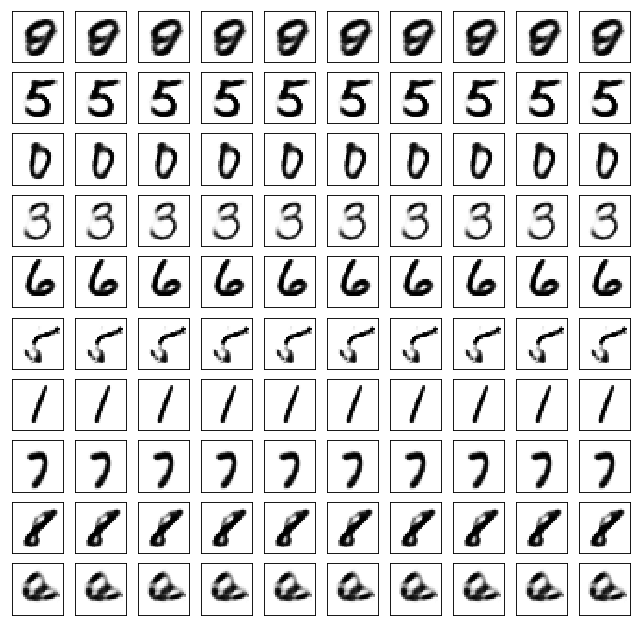

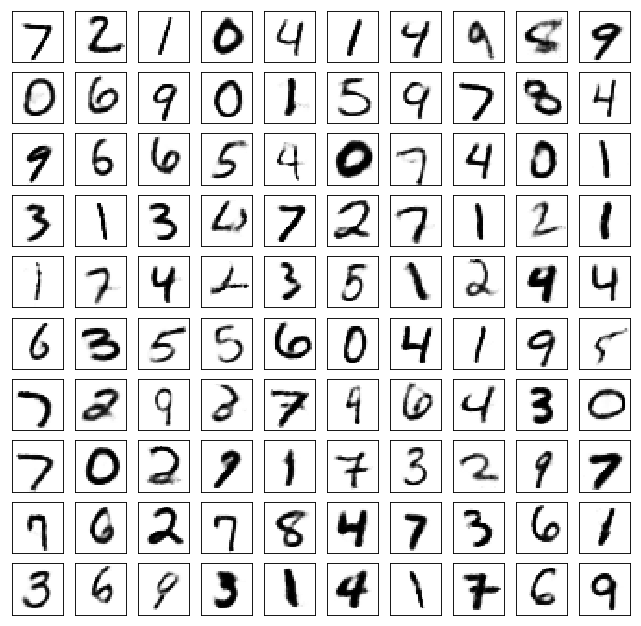

In [20]:
fixed_gen = Dec(fixed_z).cpu().data.numpy().reshape(100, 1, 28, 28)
plot_mnist(fixed_gen, (10, 10), True, fixed_folder + '%03d.png' % epoch)
fixed_reconstruction = Dec(Enc(fixed_data)).cpu().data.numpy().reshape(100, 1, 28, 28)
plot_mnist(fixed_reconstruction, (10, 10), True, recon_folder + '%03d.png' % epoch)